In [3]:
! pip install transformers
! pip install kobert-transformers
! pip install sentencepiece
! pip install konlpy
! pip install kss
! pip install imblearn

     |████████████████████████████████| 1.8MB 11.1MB/s 
     |████████████████████████████████| 3.2MB 56.4MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=57fabb0899d4faf74de913ad4fc69283bcf4d6984b0d5a03ab119a02c3c3039c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 11.5MB/s 
     |████████████████████████████████| 19.4MB 395kB/s 
     |████████████████████████████████| 460kB 59.6MB/s 
     |████████████████████████████████| 92kB 6.4MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 71kB 5.0MB

In [4]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import seaborn as sns
import re
import os
from google.colab import drive
import time,datetime
from tqdm import tqdm
import copy
from matplotlib import pyplot as plt
from kobert_transformers import get_kobert_model,get_tokenizer
import kss
drive.mount('/content/gdrive')
os.chdir('./gdrive/My Drive/기상청')
# BERT Tokenizer
tokenizer = get_tokenizer()
# BERT Model
kobert = get_kobert_model()

Mounted at /content/gdrive


# EDA

In [16]:
data = pd.read_csv('./Final_data.csv')
data.rename(columns = {'피해' : 'damage', 'Title':'title'}, inplace = True)

In [17]:
data.head()

,title,maintext,damage
0,"동국대일산병원, 무더위 속 '얼음생수 나눔 캠페인' 펼쳐",동국대학교 일산병원(병원장 이해원)은 병원 정문 앞 버스 승강장과 택시 승강장에서 ...,0
1,폭염에 따른 하수처리장 및 공공하수도 안전점검,연천군 맑은물관리사업소는 연일 이어지는 폭염속에 식수 및 생활용수 등 하수 사용량이...,0
2,"가평군, 물놀이 취약시설 안전점검 강화",▲ 물놀이취약시설현장점검나서\n\n\n\n김성기 가평군수가 폭염으로 증가하는 물놀이...,0
3,"용인송담대, 슈퍼쿨비즈 시범운영한다",▲ 대학교에서도 시행되는 용인송담대 '슈퍼쿨비즈(Supe Cool Biz)' 시범운...,0
4,"이천소방서, 한국119소년단 '불나면 대피먼저'캠페인 실시",▲한국119소년단 ‘불나면 대피먼저’캠페인\n\n\n\n이천소방서(서장 고문수)는 ...,0


피해 기사 수 1301
비피해 기사 수 6747


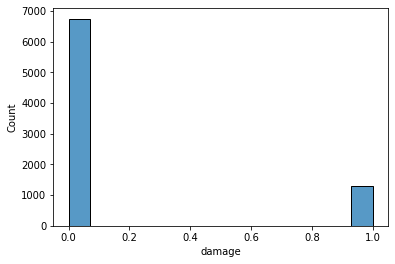

In [15]:
sns.histplot(data.damage)
print('피해 기사 수',(data.damage==1).sum())
print('비피해 기사 수',(data.damage==0).sum())

In [19]:
# cleansing 작업
def cleansing(text):
    # \n -> ' '
    text=text
    # \n+은 ' '로 치환
    text=re.sub('\n+',' ',text)
    # 괄호 제거
    text=re.sub('\(.+?\)|\[.+?\]|\<.+?\>','',text)
    # 한글, ., ,숫자가 아닌 경우 빈칸으로 치환
    text=re.sub('[^ ㄱ-ㅣ가-힣,.0-9]+','',text)
    # 문장 분리기를 활용해서 불용어가 있는 경우 제거
    result=[]
    for sentence in kss.split_sentences(text):
        for i in ['사진','기자','배포금지','무단배포','@','뉴스룸','닷컴']:
            if i in sentence:
                break
        else:
            result.append(sentence)
    return ' '.join(result)

In [22]:
data['Title']=data['title'].apply(lambda i : cleansing(i))
data['Title']=data['maintext'].apply(lambda i : cleansing(i))
data['Total']=data['Title']+'. '+data['Title']
# BERT tokenizer로 tokenizing
data['tokenized']=data['Total'].apply(lambda i : tokenizer.encode(i))
# 길이
data['len']=data['tokenized'].apply(lambda i : len(i))

Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors


mean 990.6266153081511
max 18271
75%, 95%, 99% [1239.   2344.3  4248.32]


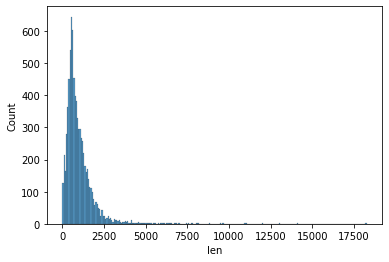

In [33]:
# Total length
sns.histplot(data['len'])
print('mean',data['len'].mean())
print('max',data['len'].max())
print('75%, 95%, 99%',np.percentile(data['len'].values,[75,95,99]))

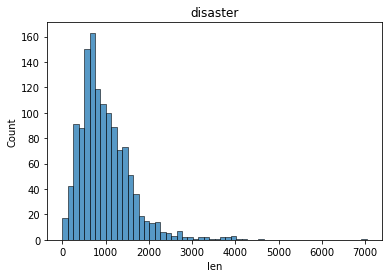

mean 988.5972328977709
max 7037
75%, 95%, 99% [1277. 2055. 3341.]


In [31]:
# 재해 인 경우
plt.title('disaster')
sns.histplot(data.loc[data['damage']==1,'len'])
plt.show()
print('mean',data.loc[data['damage']==1,'len'].mean())
print('max',data.loc[data['damage']==1,'len'].max())
print('75%, 95%, 99%',np.percentile(data.loc[data['damage']==1,'len'].values,[75,95,99]))

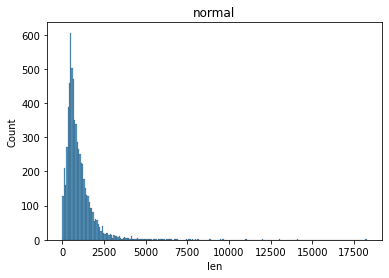

mean 991.0179338965467
max 18271
75%, 95%, 99% [1235.   2400.4  4560.24]


In [32]:
# 비재해 인 경우
plt.title('normal')
sns.histplot(data.loc[data['damage']==0,'len'])
plt.show()
print('mean',data.loc[data['damage']==0,'len'].mean())
print('max',data.loc[data['damage']==0,'len'].max())
print('75%, 95%, 99%',np.percentile(data.loc[data['damage']==0,'len'].values,[75,95,99]))

## EDA 한 줄 summary  
###total length  
mean 990  
max 18271  
95% 2344  
###disaster length  
mean 988  
max 7037  
95% 3341  
###normal length  
mean 991  
max 18271  
95% 4560  
- 비재해인 경우가 더 긴 경향을 보임(평균은 비슷)    
- KoBERT의 경우 max length가 512이므로, 길이 feature도 따로 넣어줄 생각  
- 길이의 요소가 재해/비재해에 영향을 줄 수 있음.  

# 문장별 전처리 
각 문장의 앞마다 [CLS]  
각 문장의 끝에는 [SEP]  
문장의 길이 512로 자르기  

In [34]:
# max len으로 자르고, 모자란 부분은 패딩으로 채움
data['ids'] = data['Total'].apply(lambda i : tokenizer.encode(i,add_special_tokens=True,truncation=True,padding='max_length',max_length=512))
# attention mask - mask될 부분은 0, 아닌 부분은 1
data['mask']=(torch.tensor(data['ids'].tolist()).eq(1)==0).long().tolist()

In [40]:
# Train,Val,Test split
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data.loc[:,['ids','mask','len','damage']],test_size =1000)
train_data,val_data = train_test_split(train_data.loc[:,['ids','mask','len','damage']],test_size =1000)

In [41]:
# 저장
train_data.to_pickle('./data/train_data')
val_data.to_pickle('./data/val_data')
test_data.to_pickle('./data/test_data')